In [1]:
import pandas as pd
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime

from pandas.tseries.offsets import *

In [48]:
filenames = [ 'raw-data/covis-nas1.txt', \
        'raw-data/covis-nas3.txt', \
        'raw-data/covis-nas6.txt' ]

fsz = [pd.read_csv(f, delim_whitespace=True, header=0, names=['nas','bytes','filename']) for f in filenames]

files = pd.concat(fsz)


print(files['bytes'].sum() / 2**40)

11.3796587413


In [49]:
ts = pd.DataFrame()
ts['str'] = files['filename'].str.extract('([\.\/a-zA-Z0-9]*)_([0-9T]*)', expand=True)[1]
files['datetime'] = pd.to_datetime(ts['str'], format='%Y%m%dT%H%M%S')

## Extract type
files['datatype'] = files['filename'].str.extract('([\.\/\w]*)-([A-Z]*)', expand=True)[1]

##files = files.set_index('datetime')



Type = IMAGING
Mean = 460387265.526632 bytes, stddev = 120887518.678263 bytes
     = 439.059511 MiB, 115.287322 MiB


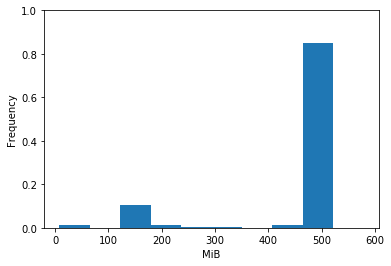

Type = DOPPLER
Mean = 3063596366.132668 bytes, stddev = 565156996.348745 bytes
     = 2921.673170 MiB, 538.975712 MiB


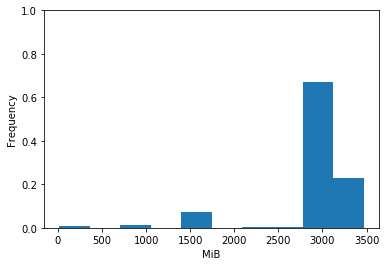

Type = DIFFUSE
Mean = 3046378.021563 bytes, stddev = 170845.703605 bytes
     = 2.905252 MiB, 0.162931 MiB


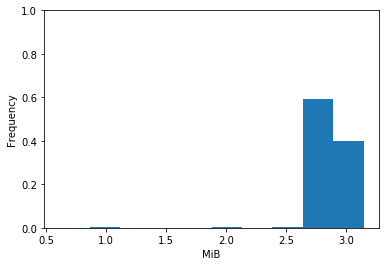

In [50]:
datatypes = ['IMAGING', 'DOPPLER', 'DIFFUSE']
files['mib'] = files['bytes'] / 2**20

for dt in datatypes:
    print("Type = %s" % dt)
        
    relevant = files[ files['datatype'] == dt ]
        
    mean_size = relevant['bytes'].mean()
    std_size = relevant['bytes'].std()
    print("Mean = %f bytes, stddev = %f bytes" % (mean_size, std_size) )
    print("     = %f MiB, %f MiB" % (relevant['mib'].mean(), relevant['mib'].std()))

    plt.figure()
    weights = np.ones_like(relevant['mib'])/float(len(relevant['mib']))
    plt.hist( relevant['mib'],normed=False, weights=weights)
    plt.ylim(0.0,1.0)
    plt.ylabel('Frequency')
    plt.xlabel('MiB')
    plt.show()

In [51]:
print(files.shape)

duplicates = files[ files.duplicated(subset='datetime') ]
print(duplicates)

dedup = files.drop_duplicates(subset='datetime')
print(dedup.shape)

dedup['count'] = 1
dedup['date'] = dedup['datetime'].dt.date
byday = dedup.groupby(['datatype','date']).sum()



(10906, 6)
Empty DataFrame
Columns: [nas, bytes, filename, datetime, datatype, mib]
Index: []
(10906, 6)


In [6]:
print(byday)

                     nas       bytes          mib  count
datatype date                                           
DIFFUSE  2011-09-28    8    24991772    23.834011      8
         2011-09-29    8    25668923    24.479793      8
         2011-09-30    8    25079022    23.917219      8
         2011-10-01    8    25434240    24.255981      8
         2011-10-02    8    25539869    24.356717      8
         2011-10-03    8    25536850    24.353838      8
         2011-10-04    8    25397544    24.220985      8
         2011-10-05    8    25491402    24.310495      8
         2011-10-06    8    25481766    24.301306      8
         2011-10-07    8    25571698    24.387072      8
         2011-10-08    8    25658564    24.469913      8
         2011-10-09    8    25694496    24.504181      8
         2011-10-10    8    25615475    24.428821      8
         2011-10-11    8    25733741    24.541608      8
         2011-10-12    8    25744417    24.551789      8
         2011-10-13    8    257

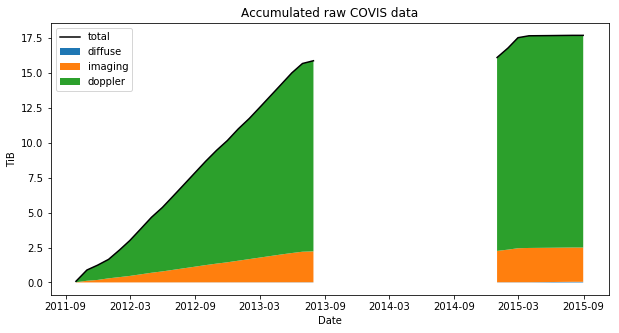

In [7]:
cumulative = pd.DataFrame(index=pd.to_datetime(byday.index.get_level_values(1)) )


for dt in datatypes:  
    relevant = byday.loc[dt]  
    cumulative[dt] = relevant['mib'].cumsum()/2**20

#     mean_size = relevant['bytes'].mean()
#     std_size = relevant['bytes'].std()
#     print("Mean = %f bytes, stddev = %f bytes" % (mean_size, std_size) )
#     print("     = %f MiB, %f MiB" % (relevant['mib'].mean(), relevant['mib'].std()))

#     plt.figure()
#     weights = np.ones_like(relevant['mib'])/float(len(relevant['mib']))
#     plt.hist( relevant['mib'],normed=False, weights=weights)
#     plt.ylim(0.0,1.0)
#     plt.ylabel('Frequency')
#     plt.xlabel('MiB')
#     plt.show()


bymonth = cumulative.groupby(pd.Grouper(level='date', freq='M')).max()
# bymonth.dropna(how='all', inplace=True)

subset =~bymonth.isnull().all(axis=1)
bymonth[subset] = bymonth[subset].fillna(method='ffill')

bymonth['total'] = bymonth.sum(1)

plt.figure()
# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))
ax.fill_between(bymonth.index, 0, bymonth['DIFFUSE'], label='diffuse')
ax.fill_between(bymonth.index, bymonth['DIFFUSE'], bymonth['IMAGING']+bymonth['DIFFUSE'],  label='imaging')
ax.fill_between(bymonth.index, bymonth['IMAGING']+bymonth['DIFFUSE'], bymonth['DOPPLER']+bymonth['IMAGING']+bymonth['DIFFUSE'], label='doppler')
ax.plot(bymonth.index, bymonth['total'],color='k')
ax.set_xlabel('Date')
ax.set_ylabel('TiB')
ax.set_title('Accumulated raw COVIS data')
ax.legend()
plt.show()

In [26]:
from datetime import datetime

## Pull out subset for linear regression
subset = bymonth[ datetime(2012,1,1):datetime(2013,6,1) ].copy()
subset['dt'] = (subset.index - subset.index[0]).days

lm = np.polyfit( subset.dt, subset.total, 1 )
print(lm)
slope = np.asscalar(lm[0]) * 2**10  # In gb/day

print("Growth rate %f GiB / day" % (slope))


[ 0.02603229  2.27883494]
Growth rate 26.657062 GiB / day


In [34]:
mission_duration = pd.Timedelta(4 * 365)

rng = pd.date_range('7/1/2018', '7/1/2022', freq='M')
data_volume = pd.DataFrame(index=rng)
data_volume['dt'] = data_volume.index - data_volume.index.min()
data_volume['gibytes'] = data_volume['dt'].apply(lambda x: x.days) * slope
data_volume['tibytes'] = data_volume['gibytes'] / 2**10

print(data_volume)

                  dt       gibytes    tibytes
2018-07-31    0 days      0.000000   0.000000
2018-08-31   31 days    826.368922   0.807001
2018-09-30   61 days   1626.080781   1.587970
2018-10-31   92 days   2452.449703   2.394970
2018-11-30  122 days   3252.161562   3.175939
2018-12-31  153 days   4078.530484   3.982940
2019-01-31  184 days   4904.899405   4.789941
2019-02-28  212 days   5651.297141   5.518845
2019-03-31  243 days   6477.666062   6.325846
2019-04-30  273 days   7277.377922   7.106814
2019-05-31  304 days   8103.746844   7.913815
2019-06-30  334 days   8903.458703   8.694784
2019-07-31  365 days   9729.827625   9.501785
2019-08-31  396 days  10556.196546  10.308786
2019-09-30  426 days  11355.908406  11.089754
2019-10-31  457 days  12182.277327  11.896755
2019-11-30  487 days  12981.989187  12.677724
2019-12-31  518 days  13808.358108  13.484725
2020-01-31  549 days  14634.727030  14.291726
2020-02-29  578 days  15407.781828  15.046662
2020-03-31  609 days  16234.150749